# urbs result analysis: where storage is used

The purpose of this notebook is to analyse the result of a suitable [urbs](https://github.com/tum-ens/urbs) (thesis branch [`haag15`](https://github.com/ojdo/urbs/tree/haag15)) scenario (probably: "battery cheap") and to analyse how often and to what extent battery is used.

Although the `haag15` branch at this point cannot discriminate between local storage (as in domestic or as in "does not reduce peak demand") and central storage (as in "can reduce peak demand"), the local distribution of usage patterns is estimated to correspond to similar patterns with real world usage. *After all, the usage patterns are always over-idealised compared to realworld operation. (But then, the difference is not too big [single digit percent], remembering the comparison study. Never mind, I digress...)* 

So, in short: go through all sites (12 "districts") and demand commodities (Elec, Heat) and extract KPIs (key performance indicators) from the storage (here: retrieval) and demand time series.

In [1]:
%matplotlib inline
import pandas as pd
import urbs

In [2]:
report_filename = 'result/rivhg15-20150723T1953/scenario_cheap_battery-20150724T0948.xlsx'

In [3]:
xls = pd.ExcelFile(report_filename)

In [4]:
ts = {}

for co in ['Elec', 'Heat']:
    # we'll exploit the fact that all timeseries sheets for a commodity
    # start with that commodity name followed by a point '.'
    ts[co] = {}
    commodity_prefix = co + '.'
    timeseries_sheets = [sn for sn in xls.sheet_names 
                         if sn.startswith(commodity_prefix)]
    
    for sheet_name in timeseries_sheets:
        site = sheet_name.replace(' timeseries', '').replace(commodity_prefix, '')
        ts[co][site] = xls.parse(sheet_name, header=[0,1])

In [5]:
kpis = {}
for co in ts.keys():
    for site in ts[co].keys():
        kpis[(co, site)] = {
            'sto_min': ts[co][site][('Storage', 'Retrieved')].min(),
            'sto_mean': ts[co][site][('Storage', 'Retrieved')].mean(),
            'sto_max': ts[co][site][('Storage', 'Retrieved')].max(),
            'dem_min': ts[co][site][('Consumed', 'Demand')].min(),
            'dem_mean': ts[co][site][('Consumed', 'Demand')].mean(),
            'dem_max': ts[co][site][('Consumed', 'Demand')].max(),
            'rrl': ((ts[co][site][('Consumed', 'Demand')] - ts[co][site][('Storage', 'Retrieved')]) 
                     / (ts[co][site][('Consumed', 'Demand')])).mean()
        }        

In [6]:
df = pd.DataFrame(kpis).T

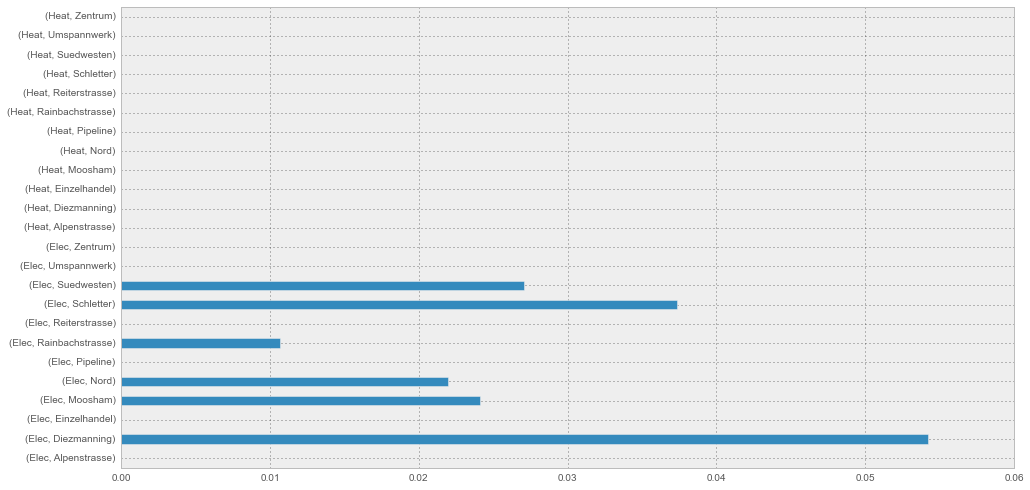

In [7]:
abs(df['sto_mean'] / df['dem_max']).plot.barh()

This looks like one could use it as a proxy measure for "peak demand reduction". Of course, mean storage retrieval does not equal demand reduction. Depending on which combination of `min`, `mean`, and `max` for storage retrieval and demand is used, values in the range from 0 to 10% can be reached. I might settle for `mean storage usage / mean demand` (up to 10 %) or `mean storage usage / maximum demand` (up to 5 %).

Let's see whether the `rrl` measure is any good:

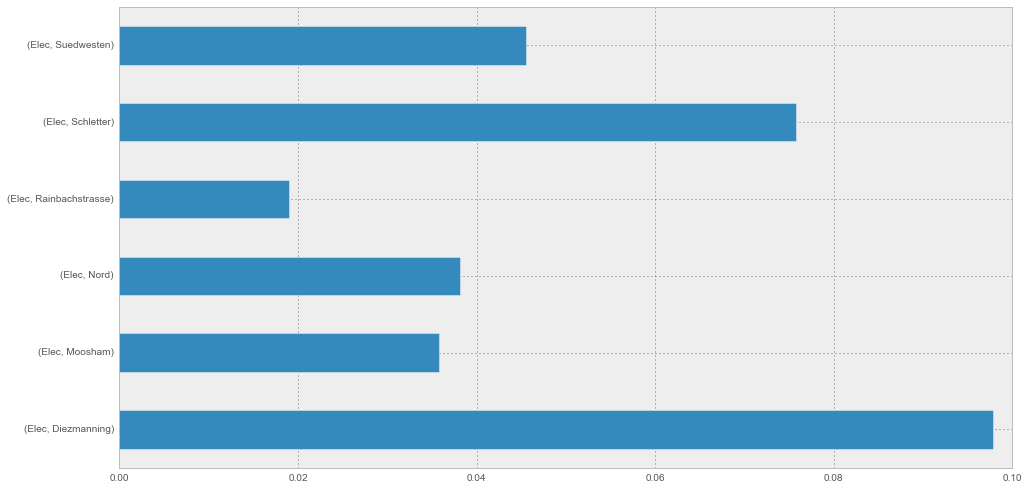

In [8]:
(1 - df.query('rrl < .9999')['rrl']).plot.barh()

That looks a bit more conservative, but might be reasonable to the extent that not massive capacities are installed. In order to see what the nearly 10% reduction in cluster "Diezmanning" look like, here is a small peak at the full time series (one year) of demand VS storage retrieval:

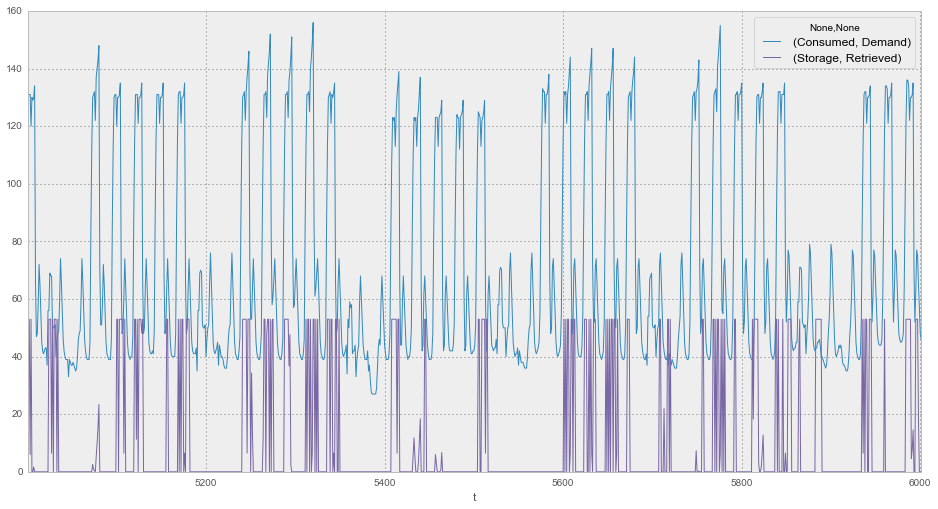

In [21]:
com, site = 'Elec', 'Diezmanning'
pd.concat([ ts[com][site][('Consumed', 'Demand')],
            ts[com][site][('Storage', 'Retrieved')]], axis=1).iloc[5000:6001,:].plot()

So as one can see, storage retrieval is mainly used to reduce peak demands. Unfortunately, this is not the case reliably, as the high peak close to `t=5100` shows. But if one is generous and assumes that the `rrl` (mean residual load, divided by mean demand) is representative for a reduction in the demand peaks, the following prefactor should be applied to the rivus peak demand:

In [22]:
peak_demand_prefactor = df['rrl'].unstack(0)
peak_demand_prefactor

,Elec,Heat
Alpenstrasse,1.000000,1
Diezmanning,0.902127,1
Einzelhandel,1.000000,1
Moosham,0.964221,1
Nord,0.961886,1
Pipeline,1.000000,1
Rainbachstrasse,0.980997,1
Reiterstrasse,1.000000,1
Schletter,0.924214,1
Suedwesten,0.954512,1


## Applying to `rivus`

In [44]:
# this is hacky. I should make urbs/rivus proper site-packages that are "just there"
import sys
if not '../rivus' in sys.path:
    sys.path.insert(0,'../rivus')
import rivus
import runhg15
import pandashp as pdshp

In [144]:
# test whether a *huge* change does something
peak_demand_prefactor['Elec'] = .5

In [147]:
rivus.save(peak_demand_prefactor, '../rivus/urbs-peak-demand-reduction.pgz')

The less refined design of `rivus` now demands its toll: the peak demand is only calculated in the `create_model` function ([issue created](https://github.com/ojdo/rivus/issues/1)). So the only way to modify the peak demand selectively is between the lines 

    model = rivus.create_model()
    
and

    prob = model.create()
    
This is where the following function `scale_peak_demand` must be inserted. Run sript `urbshg15.py` does exactly this.

In [139]:
def scale_peak_demand(model, multiplier):
    """ scale rivus peak demand DataFrame by multiplier
    
    Args:
        model: a rivus model instance
        multiplier: a DataFrame indexed by Cluster 
                    (rows) and commodity (columns)
                    
    Returns:
    """
    reduced_peak = []
    # iterate over the edges of each cluster separately
    for name, group in (model.peak.join(model.params['edge']['Cluster'])
                                  .groupby('Cluster')):
        # and multiply the edges' peak demand values by the multiplier
        # value according to the cluster `name`
        reduced_peak.append(group.drop('Cluster', axis=1) * 
                            multiplier.loc[name])
    # combine the individual frames back to single one
    return pd.concat(reduced_peak)

In [134]:
# test-drive the function
rivus_data = rivus.read_excel('../rivus/data/haag15/data.xlsx')
edge = runhg15.prepare_edge('../rivus/data/haag15/edge', '../rivus/data/haag15/building')
vertex = pdshp.read_shp('../rivus/data/haag15/vertex')
model = rivus.create_model(rivus_data, vertex, edge)

# compare peak demand
reduced_peak = scale_peak_demand(prob, peak_demand_prefactor)
print model.peak.sum()
print "\n"
print reduced_peak.sum()

Commodity
Elec    26972.450353
Heat    47823.999238
dtype: float64


Commodity
Elec    26222.480128
Heat    47823.999238
dtype: float64


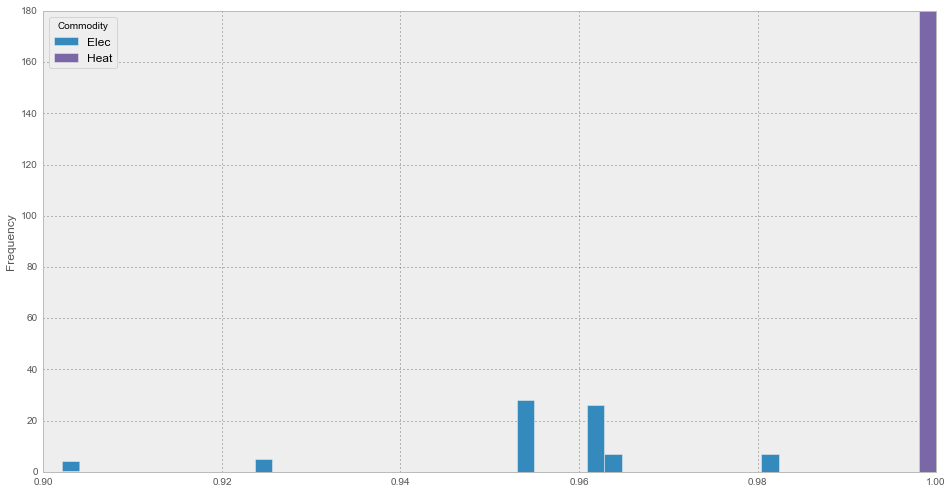

In [135]:
(reduced_peak/model.peak).plot.hist(bins=50)